# Evaluation

In [2]:
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from dinov2.models.vision_transformer import DinoVisionTransformer, vit_large
from dinov2.models.vision_transformer import vit_base
from torchvision.transforms import ToTensor,ToPILImage

/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [16]:
def extract_max_knn_performance(file_path):
    max_accuracy = None
    with open(file_path, "r") as file:
        for line in file:
            data = json.loads(line)
            for value in data.values():
                if max_accuracy is None or value > max_accuracy:
                    max_accuracy = value
    return max_accuracy if max_accuracy is not None else None

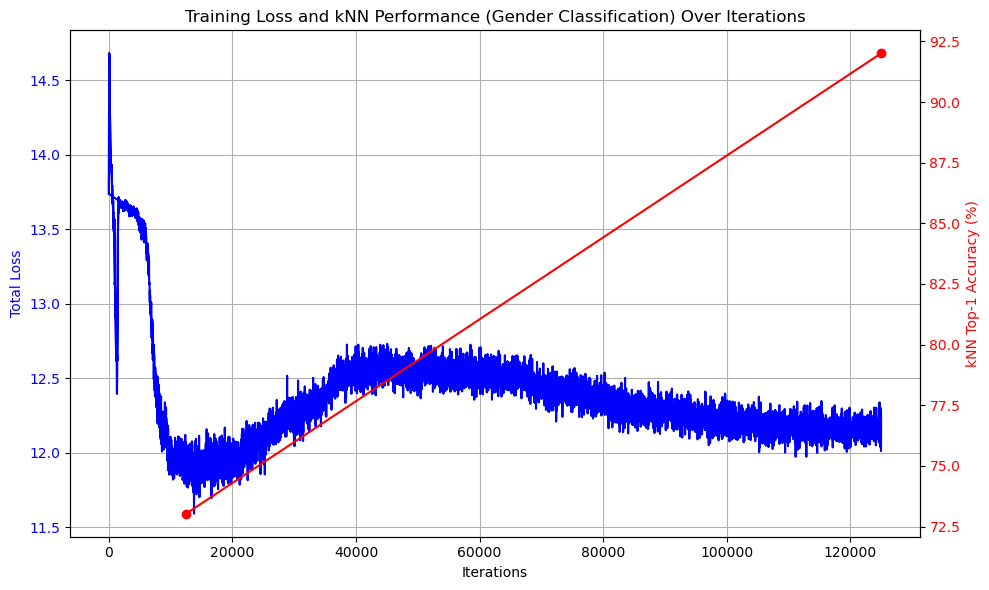

In [18]:
metrics_file = "./CelebA_gt/training_metrics.json"
knn_files = {
    12499: "./CelebA_gt/eval/training_12499/knn_gender_with_original_val_dataset/results_eval_knn.json",
    124999: "./CelebA_gt/eval/training_124999/knn_gender_with_original_val_dataset/results_eval_knn.json",
}
knn_points = {
    checkpoint: extract_max_knn_performance(path)
    for checkpoint, path in knn_files.items()
}

with open(metrics_file, "r") as file:
    metrics = [json.loads(line) for line in file]

iterations = [entry["iteration"] for entry in metrics]
total_loss = [entry["total_loss"] for entry in metrics]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(iterations, total_loss, label="Total Loss", color="blue")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Total Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

ax2 = ax1.twinx()
checkpoints = list(knn_points.keys())
knn_accuracies = list(knn_points.values())
ax2.plot(checkpoints, knn_accuracies, label="kNN Top-1 Accuracy", color="red", marker="o", linestyle="-")
ax2.set_ylabel("kNN Top-1 Accuracy (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Training Loss and kNN Performance (Gender Classification) Over Iterations")
fig.tight_layout()

plt.show()

**Comment:** Loss curve is similar to: https://github.com/facebookresearch/dinov2/issues/143#issuecomment-1651732518
TODO: Perform knn- and linear evaluation for each teacher checkpoint and plot the results. Then compare it with image retrieval performance.

## Instance Retrieval

In [1]:
import torch
import json
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [19]:
query_image_name = "162771.jpg"
CelebA_gt_CelebA_original_val_embeddings_file = "./embeddings/CelebA_gt_CelebAOriginalVal_emb.json"
CelebA_gt_CelebA_pixelated_val_embeddings_file = "./embeddings/CelebA_gt_CelebAPixelatedVal_emb.json"

In [20]:
def load_embeddings(file_path):
    with open(file_path, "r") as f:
        embeddings_data = json.load(f)
    embedding_names = list(embeddings_data.keys())
    embedding_vectors = np.array([embeddings_data[name] for name in embedding_names])
    return embedding_names, embedding_vectors

In [21]:
def visualize_top_k_results(query_image, top_k_paths, top_k_scores):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(top_k_paths) + 1, 1)
    plt.imshow(query_image)
    plt.axis("off")
    plt.title("Query Image")

    for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=2):
        img = Image.open(path)
        plt.subplot(1, len(top_k_paths) + 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Score: {score:.4f}")

    plt.show()

In [22]:
CelebA_gt_CelebA_original_val_embedding_names, CelebA_gt_CelebA_original_val_embedding_vectors = load_embeddings(CelebA_gt_CelebA_original_val_embeddings_file)
CelebA_gt_CelebA_pixelated_val_embedding_names, CelebA_gt_CelebA_pixelated_val_embedding_vectors = load_embeddings(CelebA_gt_CelebA_pixelated_val_embeddings_file)

### Ground Truth Retrievals

In [23]:
if query_image_name not in CelebA_gt_CelebA_original_val_embedding_names:
    raise ValueError(f"Query image '{query_image_name}' not found in embeddings file.")
query_embedding_np = np.array([CelebA_gt_CelebA_original_val_embedding_vectors[CelebA_gt_CelebA_original_val_embedding_names.index(query_image_name)]])

Top-5 Retrieval Results:
1. 162771.jpg (Score: 1.0000)
2. 169541.jpg (Score: 0.6865)
3. 172220.jpg (Score: 0.6435)
4. 178708.jpg (Score: 0.6379)
5. 181258.jpg (Score: 0.6107)


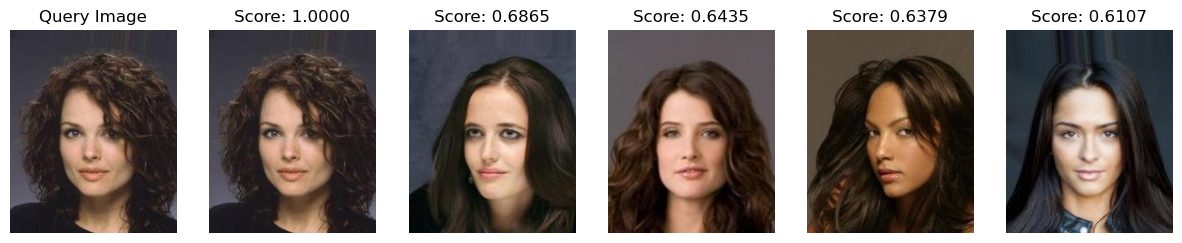

In [24]:
similarities = cosine_similarity(query_embedding_np, CelebA_gt_CelebA_original_val_embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_original/val") / CelebA_gt_CelebA_original_val_embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_original/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### "Unadapted/Pixel" with Unanonymized Query Image

Top-5 Retrieval Results:
1. 166221.jpg (Score: 0.4669)
2. 166917.jpg (Score: 0.4368)
3. 162771.jpg (Score: 0.4218)
4. 177592.jpg (Score: 0.4084)
5. 173475.jpg (Score: 0.3917)


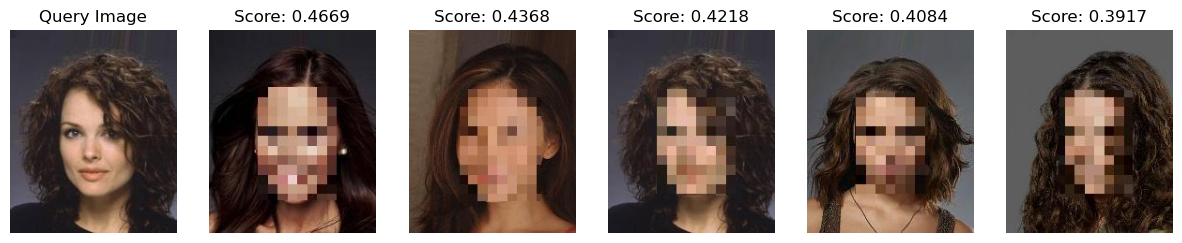

In [25]:
similarities = cosine_similarity(query_embedding_np, CelebA_gt_CelebA_pixelated_val_embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_pixelated/val") / CelebA_gt_CelebA_pixelated_val_embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_original/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### "Unadapted/Pixel" with Anonymized Query Image

In [27]:
if query_image_name not in CelebA_gt_CelebA_pixelated_val_embedding_names:
    raise ValueError(f"Query image '{query_image_name}' not found in embeddings file.")
query_embedding_np = np.array([CelebA_gt_CelebA_pixelated_val_embedding_vectors[CelebA_gt_CelebA_pixelated_val_embedding_names.index(query_image_name)]])

Top-5 Retrieval Results:
1. 162771.jpg (Score: 1.0000)
2. 173475.jpg (Score: 0.6333)
3. 181258.jpg (Score: 0.6277)
4. 172220.jpg (Score: 0.6205)
5. 165373.jpg (Score: 0.5971)


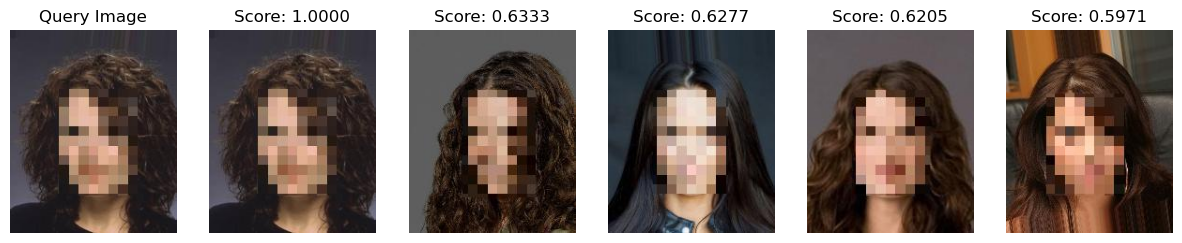

In [28]:
similarities = cosine_similarity(query_embedding_np, CelebA_gt_CelebA_pixelated_val_embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_pixelated/val") / CelebA_gt_CelebA_pixelated_val_embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_pixelated/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### Create Ground Truth Retrieval Files

#### CelebA

In [7]:
embedding_names, embedding_vectors = load_embeddings(embeddings_file)

In [8]:
ground_truth_retrievals = {}

for idx, query_image_name in enumerate(tqdm(embedding_names, desc="Processing images")):
    query_embedding = embedding_vectors[idx].reshape(1, -1) # (n_features,) -> (1, n_features)
    similarities = cosine_similarity(query_embedding, embedding_vectors)[0]

    sorted_indices = np.argsort(similarities)[::-1]
    retrieval_results = [
        {embedding_names[i]: float(similarities[i])} for i in sorted_indices # e.g., [{"162772.jpg": 1.0000}, {"179593.jpg": 0.5398}, {"174813.jpg": 0.5394}, ...]
    ]

    ground_truth_retrievals[query_image_name] = retrieval_results # e.g., {"162772.jpg": [{"162772.jpg": 1.0000}, {"179593.jpg": 0.5398}, {"174813.jpg": 0.5394}, ...]}

Processing images: 100%|██████████| 19792/19792 [42:52<00:00,  7.69it/s]  


Ground-Truth Retrievals saved to ./retrieval_ground_truths/CelebA_retrieval_ground_truths.json.


In [10]:
pickle_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl"

with open(pickle_file, "wb") as f:
    pickle.dump(ground_truth_retrievals, f)

print(f"Ground-Truth Retrievals saved to {pickle_file}.")

Ground-Truth Retrievals saved to ./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl.


In [17]:
pickle_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl"

with open(pickle_file, "rb") as f:
    ground_truth_retrievals = pickle.load(f)

In [18]:
query_image_name = "162779.jpg"

if query_image_name in ground_truth_retrievals:
    retrieval_results = ground_truth_retrievals[query_image_name]
    print(f"Retrieval results for {query_image_name}:")
    for result in retrieval_results[:5]:
        print(result)
else:
    print(f"No retrieval results found for {query_image_name}.")

Retrieval results for 162779.jpg:
{'162779.jpg': 0.9999999999999999}
{'164677.jpg': 0.5927522547458496}
{'165630.jpg': 0.5383260807071485}
{'171549.jpg': 0.5376002517886762}
{'172525.jpg': 0.5368408649312185}


## Instance Retrieval Evaluation

In [30]:
def calculate_map(ground_truth_retrievals, relevant_percent, query_embeddings_file, search_embeddings_file):
    query_embedding_names, query_embedding_vectors = load_embeddings(query_embeddings_file)
    search_embedding_names, search_embedding_vectors = load_embeddings(search_embeddings_file)

    all_aps = []

    for query_name in tqdm(embedding_names, total=len(embedding_names), desc="Processing queries"):
        print(query_name)

In [31]:
calculate_map(ground_truth_retrievals, 0.05, "./embeddings/CelebA_gt_CelebAOriginalVal_emb.json", "./embeddings/CelebA_gt_CelebAPixelatedVal_emb.json")

Processing queries: 100%|██████████| 19792/19792 [00:00<00:00, 312567.92it/s]

162771.jpg
162772.jpg
162773.jpg
162774.jpg
162775.jpg
162776.jpg
162777.jpg
162778.jpg
162779.jpg
162780.jpg
162781.jpg
162782.jpg
162783.jpg
162784.jpg
162785.jpg
162786.jpg
162787.jpg
162788.jpg
162789.jpg
162790.jpg
162791.jpg
162792.jpg
162793.jpg
162794.jpg
162795.jpg
162796.jpg
162797.jpg
162798.jpg
162799.jpg
162800.jpg
162801.jpg
162802.jpg
162803.jpg
162804.jpg
162805.jpg
162806.jpg
162807.jpg
162808.jpg
162809.jpg
162810.jpg
162811.jpg
162812.jpg
162813.jpg
162814.jpg
162815.jpg
162816.jpg
162817.jpg
162818.jpg
162819.jpg
162820.jpg
162821.jpg
162822.jpg
162823.jpg
162824.jpg
162825.jpg
162826.jpg
162827.jpg
162828.jpg
162829.jpg
162830.jpg
162831.jpg
162832.jpg
162834.jpg
162835.jpg
162836.jpg
162837.jpg
162838.jpg
162839.jpg
162840.jpg
162841.jpg
162842.jpg
162843.jpg
162844.jpg
162845.jpg
162846.jpg
162847.jpg
162848.jpg
162849.jpg
162850.jpg
162851.jpg
162852.jpg
162853.jpg
162854.jpg
162855.jpg
162856.jpg
162857.jpg
162858.jpg
162859.jpg
162860.jpg
162861.jpg
162862.jpg